### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [3636]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from collections import defaultdict
import operator

In [3829]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        y_range = y[np.argsort(x, axis=0)]
        classes, counts = np.unique(y, return_counts=True)
        classes_arrays = (y_range == np.expand_dims(np.expand_dims(classes, 1), 1))
        kl = np.cumsum(classes_arrays, 1)
        kr = counts.reshape(classes.shape[0], 1, 1) - kl
        l = np.arange(1, y.shape[0] + 1)
        r = y.shape[0] - l
        l, r = l.reshape(-1, 1), r.reshape(-1, 1)
        r[r == 0] = 1
        
        if self.criterion == 'error':
            maxkl = np.max(kl, 0)
            maxkr = np.max(kr, 0)
            functional = maxkr + maxkl
            
        if self.criterion == 'gini':
            kl2, kr2 = kl ** 2, kr ** 2
            sum_kl2, sum_kr2 = np.sum(kl2, 0), np.sum(kr2, 0)
            functional = sum_kl2 / l + sum_kr2 / r
            
        if self.criterion == 'entropy':
            logkr, logkl = np.log(kr / r + 10e-8), np.log(kl / l + 10e-8)
            functional = np.sum(kl * logkl, 0) + np.sum(kr * logkr, 0)
            
        threshold_index, feature_id = np.unravel_index(np.argmax(functional, axis=None), functional.shape)
        return feature_id, x[threshold_index][feature_id], functional[threshold_index][feature_id]
            
        # Make a Fisher test
                    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth != self.max_depth and np.unique(y).shape[0] != 1:
            feature_id, threshold, gain = self.__find_threshold(x, y)
            self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold, gain)
            left_x, right_x, left_y, right_y = self.__div_samples(x, y, feature_id, threshold)
            if left_y.shape[0] and right_y.shape[0] and left_y.shape[0] >= self.min_samples_split and right_y.shape[0] >= self.min_samples_split:
                self.__fit_node(left_x, left_y, 2 * node_id + 1, depth + 1)
                self.__fit_node(right_x, right_y, 2 * node_id + 2, depth + 1)
                return
        label = scipy.stats.mode(y)[0][0]
        proba = np.sum((y == label)) / y.shape[0]
        self.tree[node_id] = (self.__class__.LEAF_TYPE, label, proba)
        
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold, _ = node
            if x[feature_id] <= threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        features = defaultdict(int)
        for id_ in self.tree:
            if not self.tree[id_][0]:
                features[self.tree[id_][1]] += self.tree[id_][3]
        return dict(sorted(features.items(), key=lambda x: x[1], reverse=True))

In [3830]:
my_clf = MyDecisionTreeClassifier()
clf = DecisionTreeClassifier(min_samples_split=2)

In [3859]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3, stratify=wine.target)

In [3860]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [3861]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8703703703703703
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [3837]:
%time clf.fit(X_train, y_train)

CPU times: user 1.53 ms, sys: 929 µs, total: 2.46 ms
Wall time: 2.53 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [3673]:
%time my_clf.fit(X_train, y_train)

CPU times: user 6.79 ms, sys: 1.56 ms, total: 8.35 ms
Wall time: 7.71 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [3917]:
def one_hot(df, column):
    data = pd.get_dummies(df[column])
    data.columns = [column + '_{}'.format(i) for i in range(data.shape[1])]
    return df.join(data).drop([column], 1)

In [3918]:
df = pd.read_csv('Speed_Dating_Data.csv', encoding='latin1')

In [3919]:
df = one_hot(df, 'career_c')
df = one_hot(df, 'field_cd')
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['undergra'], axis=1)
df = df.drop(['from', 'zipcode'], axis=1)
df = df.drop(['income'], axis=1)
df = df.drop(['career', 'like'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o', 'dec'], axis=1)

In [3920]:
columns = np.array(df.dtypes[(df.dtypes != 'int64') & (df.dtypes != 'float64')].index)
df = df.drop(columns, 1)
df = df.fillna(-1e8)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()

df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pairs = pd.merge(df_male, df_female, left_on=['pid'], right_on=['iid_f'], how='inner')
df_pairs = df_pairs.drop(['iid', 'pid'], axis=1)
X = df_pairs.drop(['match'], axis=1).values
y = df_pairs['match'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

My Tree:

In [3921]:
my_clf = MyDecisionTreeClassifier(criterion='entropy')
print(f1_score(my_clf.fit_predict(X_train, y_train, X_test), y_test, average='macro'))

0.5840044125758412


sklearn Tree:

In [3922]:
clf = DecisionTreeClassifier(max_depth=2, criterion='gini')
clf.fit(X_train, y_train)
print(f1_score(my_clf.predict(X_test), y_test, average='macro'))

0.5840044125758412


Точность случайного гадания:

In [3923]:
y_random = y_test.copy()
np.random.shuffle(y_random)
print(f1_score(y_random, y_test, average='macro'))print(f1_score(y_random, y_test))

0.5380766621438263
0.16417910447761194


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [3924]:
for criterion in ['error', 'gini', 'entropy']:
    my_clf = MyDecisionTreeClassifier(criterion=criterion)
    print(criterion, f1_score(my_clf.fit_predict(X_train, y_train, X_test), y_test, average='macro'))

error 0.5704678722270062
gini 0.6442057942057942
entropy 0.5840044125758412


In [3925]:
def fit_predict_clf(*data, **params):
    X_train, X_test, y_train, y_test = data
    clf = MyDecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)
    return f1_score(clf.predict(X_test), y_test, average='macro')

def get_depth_scores(max_depth, criterion='gini', *data):
    result = []
    for depth in range(max_depth):
        result.append((depth, fit_predict_clf(*data, criterion=criterion, max_depth=depth)))
    return result

def get_leaf_score(min_samples_split, criterion='gini', *data):
    result = []
    for sapmles in range(min_samples_split):
        result.append((sapmles, fit_predict_clf(*data, criterion=criterion, min_samples_split=sapmles)))
    return result

In [3926]:
depth_points = get_depth_scores(20, 'gini', X_train, X_test, y_train, y_test)
leaf_points = get_leaf_score(10, 'gini', X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'max_depth')

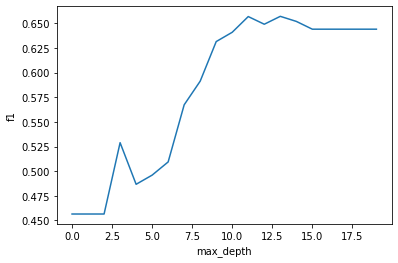

In [3927]:
points = np.swapaxes(np.array(depth_points), 0, 1)
plt.plot(points[0], points[1])
plt.ylabel('f1')
plt.xlabel('max_depth')

Text(0.5, 0, 'min_samples_split')

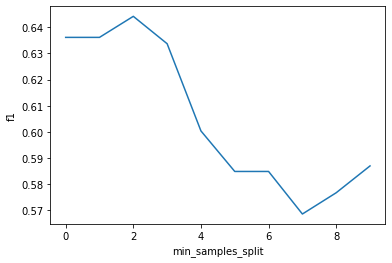

In [3928]:
points = np.swapaxes(np.array(leaf_points), 0, 1)
plt.plot(points[0], points[1])
plt.ylabel('f1')
plt.xlabel('min_samples_split')

На этом датасете дерево строится до весьма небольшой глубины:

In [3937]:
my_clf = MyDecisionTreeClassifier(max_depth=2, criterion='gini')
print(f1_score(my_clf.fit_predict(X_train, y_train, X_test), y_test, average='macro'))
print(my_clf.tree)

0.4565499351491569
{0: (0, 57, 5.0, 2792.6844896597167), 1: (0, 62, -100000000.0, 1054.0239126945917), 3: (1, 0, 0.9885714285714285), 4: (1, 0, 0.9515463917525773), 2: (0, 63, 8.0, 1764.554128835764), 5: (1, 0, 0.7978766843609637), 6: (1, 0, 0.5380116959064327)}


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Аналогичную ситуацию наблюдаем на примере дерева из sklearn

0.4565499351491569


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


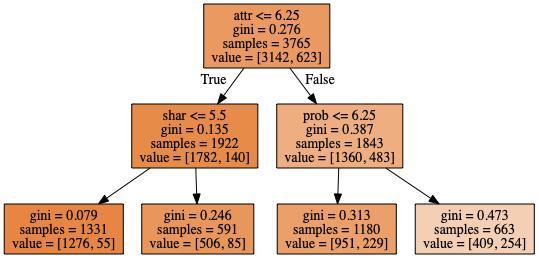

In [3930]:
clf = DecisionTreeClassifier(max_depth=2, criterion='gini')
clf.fit(X_train, y_train)
print(f1_score(my_clf.predict(X_test), y_test, average='macro'))
export_graphviz(clf, feature_names=df_pairs.drop(['match'], axis=1).columns, 
out_file='sklearn_tree.dot', filled=True)
!dot -Tpng 'sklearn_tree.dot' -o 'sklearn_tree.png'
Image(filename='sklearn_tree.png')

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [3931]:
def get_important_features(clf, columns):
    features = clf.get_feature_importance()
    i = 0
    for feature in features:
        print(columns[feature], '\t', features[feature])
        i += 1
        if i >= 10:
            break

In [3938]:
get_important_features(my_clf, df_pairs.drop(['match'], axis=1).columns)

attr 	 2792.6844896597167
prob 	 1764.554128835764
shar 	 1054.0239126945917


В плане feature importance тоже мало интересного, он обучился только по трем фичам.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Все понятно

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

